# Classification models training and evaluation


# Importing libraries

In [1]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import warnings
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

warnings.filterwarnings("ignore")



In [2]:
#Upload the data 
df = pd.read_csv("data.csv")

#Eliminate " Unnamed: 32" & "id"
df= df.drop("Unnamed: 32",axis=1)
df= df.drop("id", axis=1)
df= df.replace({"M":1, "B":0})

#Drop less important features
drop_col = ["fractal_dimension_se", "smoothness_se", "fractal_dimension_mean", "texture_se", "symmetry_se"]

df=df.drop(drop_col, axis=1)

# Removing features

In this model it will be eliminated the 10 less important features.

In [3]:
to_drop = ['fractal_dimension_worst',
            'concavity_se',
            'perimeter_se',
            'area_se',
            'smoothness_mean',
            'compactness_se',
            'concave points_se',
            'symmetry_mean',
            'radius_se',
            'compactness_mean'] 

new_df = df.drop(to_drop, axis=1)
new_df

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,concavity_mean,concave points_mean,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst
0,1,17.99,10.38,122.80,1001.0,0.30010,0.14710,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601
1,1,20.57,17.77,132.90,1326.0,0.08690,0.07017,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750
2,1,19.69,21.25,130.00,1203.0,0.19740,0.12790,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613
3,1,11.42,20.38,77.58,386.1,0.24140,0.10520,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638
4,1,20.29,14.34,135.10,1297.0,0.19800,0.10430,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,1,21.56,22.39,142.00,1479.0,0.24390,0.13890,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060
565,1,20.13,28.25,131.20,1261.0,0.14400,0.09791,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572
566,1,16.60,28.08,108.30,858.1,0.09251,0.05302,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218
567,1,20.60,29.33,140.10,1265.0,0.35140,0.15200,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087


In [4]:
#Creating my predictive variable (X) and my target variable (Y)

#y = Target Variable
y = df.iloc[:,0]

#X= Predictors
X= new_df.iloc[:,1:]


## Train-test split

Rather than using the default train_test_split provided by scikit-learn, we should try to make sure our splits accurately represent the distribution of our target variable. A very simple way to do this is to use the stratify parameter when calling the train_test_split function.

Making this small change ensures that the train and test sets follow the same distribution as our original dataset.

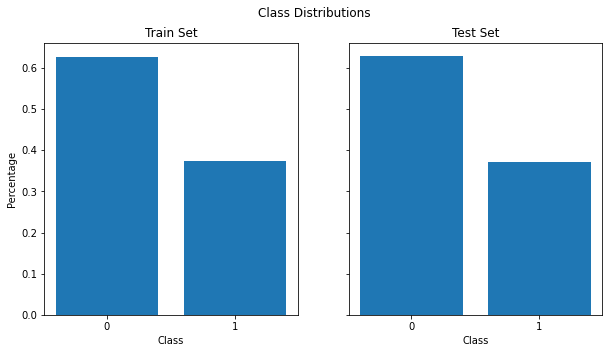

In [5]:
# Call train_test_split with the `stratify` parameter
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, 
                                                    stratify=y)

# Get the value counts of our train and test sets
y_train_vals = y_train.value_counts()
y_test_vals = y_test.value_counts()

# Plot the distributions to check if they match the original
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
ax1.bar(y_train_vals.index.astype(str), y_train_vals.values/sum(y_train_vals.values))
ax2.bar(y_test_vals.index.astype(str), y_test_vals.values/sum(y_test_vals.values))
plt.suptitle("Class Distributions")
ax1.set_title("Train Set")
ax1.set_xlabel("Class")
ax1.set_ylabel("Percentage")
ax2.set_title("Test Set")
ax2.set_xlabel("Class")
plt.show()

## Theory: RandomizedSearchCV vs GridSearchCV

### GridSearchCV:

-*Exhaustive Search:* Grid search performs an exhaustive search over a predefined hyperparameter grid. You specify the values or ranges for each hyperparameter you want to tune, and it tries every possible combination. This guarantees that you'll explore the entire search space.

-*Complete Search:* Grid search is suitable when you have a relatively small hyperparameter space and want to ensure that no combination is overlooked. If you have a good idea of where the optimal hyperparameters might lie, grid search can be effective.

-*Deterministic Results:* Since grid search tries all combinations, it will always give you the same result if you run it multiple times with the same hyperparameter grid and data.

### RandomizedSearchCV:

-*Random Sampling:* Randomized search, on the other hand, randomly samples hyperparameter combinations from predefined ranges or distributions. It doesn't try every possible combination but rather focuses on a random subset of the search space. This can be more efficient, especially when the hyperparameter space is large.

-*Resource Efficiency:* Randomized search is well-suited for situations where you have limited computational resources. Since it doesn't exhaustively explore all combinations, it can often find good hyperparameters more quickly.

-*Stochastic Nature:* Randomized search is inherently stochastic due to its random sampling approach. It may not always find the absolute best hyperparameters, but it can discover good ones and is less prone to getting stuck in local optima.

# 1 - Random Forest Classifier

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

## 1.1 Randomised Search CV

We can use scikit learn and RandomisedSearchCV where we can define the grid, the random forest model will be fitted over and over by randomly selecting parameters from the grid. 

In [6]:

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [7]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X, y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [8]:
# The best parameters from fitting the random search
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': False}

## 1.2 Training the model

In [28]:
#Tuned model
tuned_model = RandomForestClassifier(n_estimators= 800, 
                                min_samples_split= 2,
                                min_samples_leaf= 2,
                                max_features= 'sqrt',
                                max_depth= 50,
                                bootstrap= False,
                                random_state=99)

## 1.3 StratifiedKFold Cross-Validation

The goal of the following code is to perform cross-validation, train the model on different subsets of the training data, and calculate the average F1 score to assess the model's overall performance.

The *F1 Score* is a balance between precision and recall. It is given by the formula (2 * Precision * Recall) / (Precision + Recall). This metric proves to be suitable for imbalanced datasets, eliminating the shortcomings of the plain accuracy metric.

In [10]:
# Import StratifiedKFold, RandomForestClassifier, and f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier  # Import RandomForestClassifier

# Initialize an empty list to store F1 scores from each fold
f1_scores = []

# Split the data using StratifiedKFold and get the average f1 score
skf = StratifiedKFold()
mean_f1 = 0
for train_ix, test_ix in skf.split(X_train, y_train):
    X_train_1, X_test_1 = X_train.iloc[train_ix], X_train.iloc[test_ix]
    y_train_1, y_test_1 = y_train.iloc[train_ix], y_train.iloc[test_ix]

    # Create and configure the RandomForestClassifier instance
    rf_clf = tuned_model  # You can configure hyperparameters here
    rf_clf.fit(X_train_1, y_train_1)
    predictions = rf_clf.predict(X_test_1)
    
    # Calculate the F1 score for this fold and append it to the list
    fold_f1 = f1_score(y_test_1, predictions)
    f1_scores.append(fold_f1)
    
# Calculate the mean F1 score
mean_f1 = np.mean(f1_scores)

# Calculate the standard deviation of F1 scores
std_f1 = np.std(f1_scores)

print(f'Mean F1 Score: {mean_f1}')
print(f'Standard Deviation of F1 Score: {std_f1}')


Mean F1 Score: 0.952560454411327
Standard Deviation of F1 Score: 0.02574231369292781


The *mean F1 score* is an average value of the F1 scores obtained in each fold of your cross-validation. An F1 score is a measure of a model's accuracy that considers both precision and recall. In this case, the mean F1 score is approximately 0.952, which indicates that, on average, the model's precision and recall are quite high, suggesting that it's doing a good job of correctly classifying both positive and negative instances.

The *standard deviation* measures the variability or spread of the F1 scores across the different folds. A low standard deviation suggests that the F1 scores are consistent across folds, indicating that your model's performance is stable. In this case, a standard deviation of approximately 0.025 is relatively small, suggesting that the model's performance is consistent and not highly variable across different subsets of your data.

The cross-validated F1 scores are quite high and consistent, which is a positive sign for the performance of your model on the training data.

## 1.4 Final RF Model Evaluation

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        90
           1       1.00      0.92      0.96        53

    accuracy                           0.97       143
   macro avg       0.98      0.96      0.97       143
weighted avg       0.97      0.97      0.97       143



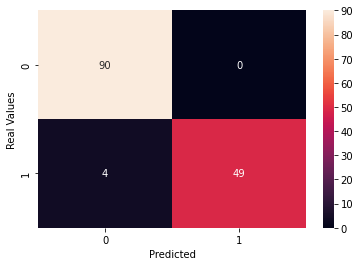

In [29]:
tuned_model.fit(X_train, y_train)

y_pred=tuned_model.predict(X_test)

confusion_matrix_tuned = pd.crosstab(y_test, y_pred, rownames=['Real Values'], colnames=['Predicted'])
sns.heatmap(confusion_matrix_tuned, annot=True)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

*Accuracy* = Simple measure of total error. The proportion of predictions that are correct. In this case 0.97.

*Sensitivity (recall)* = measures the strength of the model to predict a positive outcome - the proportion of the 1s that it correctly identifies. 

Overall, the results indicate that your model has performed well on this classification task. It has high precision and recall for both classes, resulting in high F1-scores. The accuracy is also high at 97%, suggesting that your model is making accurate predictions.

In [31]:
# Metrics:

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

precision = precision_score(y_test, y_pred)
print(f'Precision: {precision}')

recall = recall_score(y_test, y_pred)
print(f'Sensitivity (Recall): {recall}')

f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

Accuracy: 0.972027972027972
Precision: 1.0
Sensitivity (Recall): 0.9245283018867925
F1 Score: 0.9607843137254902


These metrics indicate that the classification model exhibits outstanding performance in the task it is performing. 

Both precision and recall are exceptionally high, suggesting that the model is capable of correctly classifying the majority of positive instances while maintaining a low number of false positives. 

Accuracy is also high, signifying that the model correctly classifies the majority of instances overall. The F1 score, a measure that combines precision and recall, is also high in this case.

AUC=0.9622641509433962


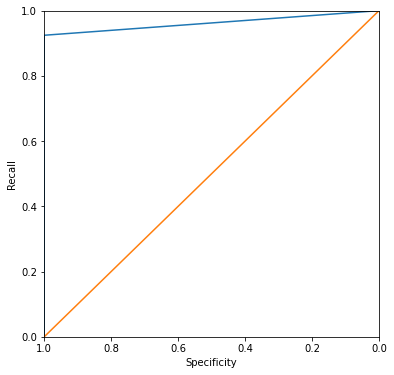

In [13]:
#ROC curve 

from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(np.array(y_test), y_pred)

roc_df =pd.DataFrame({'recall':tpr,  'specificity': 1 - fpr})
auc = metrics.roc_auc_score(np.array(y_test), y_pred)

ax = roc_df.plot(x='specificity', y='recall', figsize =(6,6), legend = False)
ax.set_ylim(0,1)
ax.set_xlim(1,0)
ax.plot((1,0),(0,1))
ax.set_xlabel('Specificity')
ax.set_ylabel('Recall')


print("AUC="+str(auc))

*AUC:* indicates excellent performance for your classification model. 

The AUC measures the ability of the model to distinguish between positive and negative cases, with a value of 1.0 representing perfect discrimination and 0.5 representing random guessing. 

An AUC value close to 1 suggests that your model is doing an outstanding job in separating the classes, making it highly effective for its intended purpose.

# 2- SVM Classifier

The objective of the support vector machine algorithm is to find a hyperplane in an N-dimensional space(N — the number of features) that distinctly classifies the data points. In this case, classify de data points as BENINGN or MALIGNOUS.

As it can be observed in most of the graphs in *1_ExploratoryAnalysis* the data can be separable with a linear hiperplane. So we postulate the following hypothesis:

*Ho:* The data is linearrly separable

## 2.1 Scaling the data

In [15]:
#Scale the data

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 2.2 Randomised Search CV

In [19]:
grid = {
    'C':[0.01,0.1,1,10],
    'kernel' : ["linear","poly","sigmoid"],
    'degree' : [1,3,5,7],
    'class_weight': ['balanced'],
    'gamma' : [0.01,1] }

In [20]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score

# First create the base model to tune
svm  = SVC ()

# Create a scorer for F1 score
f1_scorer = make_scorer(f1_score)

# Create a StratifiedKFold cross-validation strategy
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create a RandomizedSearchCV object with stratified cross-validation
svm_cv = RandomizedSearchCV(svm, grid, n_iter=100, cv=stratified_cv, scoring=f1_scorer)

# Fit the RandomizedSearchCV object to the training data
svm_cv.fit(X_train_scaled, y_train)



RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=SVC(), n_iter=100,
                   param_distributions={'C': [0.01, 0.1, 1, 10],
                                        'class_weight': ['balanced'],
                                        'degree': [1, 3, 5, 7],
                                        'gamma': [0.01, 1],
                                        'kernel': ['linear', 'poly',
                                                   'sigmoid']},
                   scoring=make_scorer(f1_score))

In [21]:
# Print the best parameters found by RandomizedSearchCV
print("Best Parameters:", svm_cv.best_params_)

Best Parameters: {'kernel': 'linear', 'gamma': 0.01, 'degree': 1, 'class_weight': 'balanced', 'C': 0.1}


## 2.3 Training the model

In [22]:
#Tuned model
svm_tuned_model = SVC(kernel= 'linear', 
                                gamma= 0.01,
                                degree= 1,
                                class_weight= 'balanced',
                                C= 0.1,
                                random_state=99)


In [23]:


# Initialize an empty list to store F1 scores from each fold
f1_scores = []

# Split the data using StratifiedKFold and get the average f1 score
skf = StratifiedKFold()
mean_f1 = 0
for train_ix, test_ix in skf.split(X_train_scaled, y_train):
    X_train_1, X_test_1 = X_train_scaled[train_ix], X_train_scaled[test_ix]
    y_train_1, y_test_1 = y_train.iloc[train_ix], y_train.iloc[test_ix]

    # Create and configure the RandomForestClassifier instance
    rf_clf = svm_tuned_model  # You can configure hyperparameters here
    rf_clf.fit(X_train_1, y_train_1)
    predictions = rf_clf.predict(X_test_1)
    
    # Calculate the F1 score for this fold and append it to the list
    fold_f1 = f1_score(y_test_1, predictions)
    f1_scores.append(fold_f1)
    
# Calculate the mean F1 score
mean_f1 = np.mean(f1_scores)

# Calculate the standard deviation of F1 scores
std_f1 = np.std(f1_scores)

print(f'Mean F1 Score: {mean_f1}')
print(f'Standard Deviation of F1 Score: {std_f1}')


Mean F1 Score: 0.9649722320690064
Standard Deviation of F1 Score: 0.0233833174189576


*Mean F1 Score (0.965)*: This is the average F1 Score calculated over different folds or iterations of the cross-validation. An F1 Score of 0.965 suggests that, on average, the SVM model has a strong balance between precision and recall. It indicates that the model is effective at correctly classifying positive and negative cases in your data.

*Standard Deviation of F1 Score (0.023)*: This measures the variability or spread of the F1 Scores across the cross-validation folds. A low standard deviation (0.023 in this case) implies that the F1 Scores are relatively consistent from one fold to another. In other words, the model's performance is stable and doesn't fluctuate significantly when tested on different subsets of your training data.

Overall, these results suggest that the SVM model, with the hyperparameters obtained through randomized search, is performing consistently well. The mean F1 Score of 0.965 indicates a high level of accuracy and robustness in classification, and the low standard deviation suggests that this performance is reliable across different data splits. This is a positive outcome and indicates that the model is well-suited for the task at hand.

## 2.4 Final SVM model evaluation

              precision    recall  f1-score   support

           0       0.99      0.98      0.98        90
           1       0.96      0.98      0.97        53

    accuracy                           0.98       143
   macro avg       0.98      0.98      0.98       143
weighted avg       0.98      0.98      0.98       143



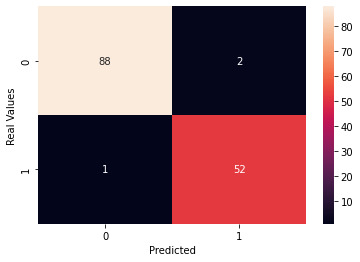

In [26]:
svm_tuned_model.fit(X_train_scaled, y_train)

y_pred=svm_tuned_model.predict(X_test_scaled)

confusion_matrix_tuned = pd.crosstab(y_test, y_pred, rownames=['Real Values'], colnames=['Predicted'])
sns.heatmap(confusion_matrix_tuned, annot=True)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

AUC=0.979454926624738


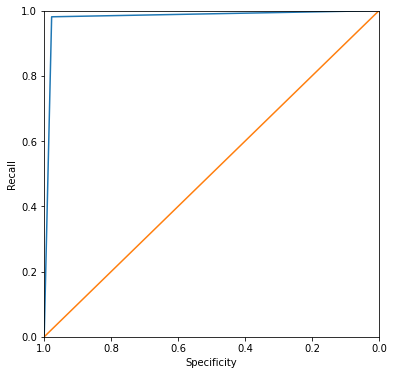

In [27]:
#ROC curve 

from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(np.array(y_test), y_pred)

roc_df =pd.DataFrame({'recall':tpr,  'specificity': 1 - fpr})
auc = metrics.roc_auc_score(np.array(y_test), y_pred)

ax = roc_df.plot(x='specificity', y='recall', figsize =(6,6), legend = False)
ax.set_ylim(0,1)
ax.set_xlim(1,0)
ax.plot((1,0),(0,1))
ax.set_xlabel('Specificity')
ax.set_ylabel('Recall')


print("AUC="+str(auc))

An AUC value of 0.979 suggests that the Support Vector Machine (SVM) model has a very high discriminatory ability, meaning it's effectively distinguishing between the two classes in your dataset.

In general, an AUC of 0.5 indicates random guessing, while an AUC of 1.0 represents a perfect classifier. An AUC of 0.979 is very close to the ideal performance, indicating that your model is making highly accurate predictions and is well-suited for the classification task at hand.

Combined with the previously mentioned high F1 Score and low standard deviation, this AUC value further confirms the strong performance of the SVM model on your dataset.

In [25]:
# Metrics:

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

precision = precision_score(y_test, y_pred)
print(f'Precision: {precision}')

recall = recall_score(y_test, y_pred)
print(f'Sensitivity (Recall): {recall}')

f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

Accuracy: 0.972027972027972
Precision: 1.0
Sensitivity (Recall): 0.9245283018867925
F1 Score: 0.9607843137254902


It seems that the data can be linearily separeated.

These metrics collectively indicate that your model is performing quite well, with a high accuracy, perfect precision, a reasonably high recall, and a good F1 Score.

# 3. Conclusion:
Given that the model is a medical classifier where misclassifying a positive case (1) can have severe consequences, a high recall (sensitivity) is crucial. You want to minimize false negatives because missing a true positive in a medical context can be very harmful.

In conclusion, for a medical classifier, it's important to prioritize recall (sensitivity) to minimize the risk of missing true positive cases while keeping precision high to minimize false positives. 

Comparing the two medical classifier models, the SVM model appears to be better for medical purposes based on the metrics. Here's why:

-*Accuracy, Precision, Sensitivity (Recall), and F1 Score:* The SVM model and the RF model have identical values for accuracy, precision, recall, and F1 score. This indicates that both models are equally good in terms of overall performance, precision, and recall.

-*AUC (Area Under the ROC Curve):* The AUC represents the ability of a model to distinguish between positive and negative cases. In this context, a higher AUC value is better. The SVM model has an AUC of 0.979, which is higher than the RF model's AUC of 0.96. This suggests that the SVM model has a better ability to differentiate between positive and negative cases, which is particularly important in a medical context. A higher AUC indicates a better trade-off between the true positive rate and the false positive rate.

Given the higher AUC of the SVM model, it is the preferred choice for medical purposes. It demonstrates better discrimination between positive and negative cases, which is crucial in medical applications where correctly identifying positive cases and minimizing false positives are of utmost importance.